In [78]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from xgboost import XGBClassifier

# %config InlineBackend.figure_formats =['retina']  # or svg
%matplotlib inline

In [ ]:
df_buy = pd.read_csv('lisbon_buy_house_6302.csv')
df_buy.head()

In [ ]:
df_buy.tail()

In [ ]:
# steps to convert str to int or float, first remove unnecessary characters
df_buy['Price'] = df_buy['Price'].str.replace(' ', '')
df_buy['Price'] = df_buy['Price'].str.replace('€', '')
df_buy['Address'] = df_buy['Address'].str.replace('Lisboa ', '')
df_buy['Address'] = df_buy['Address'].str.replace('-', '')
df_buy['City'] = df_buy['Address'].str.split(',', expand=True)[0]
df_buy['Division'] = df_buy['Address'].str.split(',', expand=True)[1]
df_buy['City'] = df_buy['City'].str.strip()  # removing leading and tailing white spaces
df_buy['Size'] = df_buy['Size'].str.replace('m2', '')

In [ ]:
df_buy.head()

In [ ]:
# convert to int/float
df_buy['Price'] = pd.to_numeric(df_buy['Price'], errors='coerce')
df_buy['Size'] = pd.to_numeric(df_buy['Size'], errors='coerce')
df_buy['Bath'] = pd.to_numeric(df_buy['Bath'], errors='coerce')
df_buy['Bed'] = pd.to_numeric(df_buy['Bed'], errors='coerce')
print(df_buy.dtypes)

In [ ]:
df_buy.head()

In [ ]:
df_buy.to_csv(r'lisbon_buy_6302_052922.csv', index = False, header=True)

In [ ]:
# data cleaned in excel

In [ ]:
df = pd.read_csv('lisbon_buy_6302_052922_final.csv')

In [ ]:
df.head()

####  Loading csv that has predicted rent and other caluculated cols added
Assumptions: <br>
-30% downpayment (standard in Portogul)<br>
-4% interest rate (r(monthly rate): 0.003333)<br>
-30 year fixed rate (n(term): 360)<br>
M = P*r(1+r)^n/((1+r)^n) - 1)<br>
-1% property tax<br>
-0.5% property insurance<br>
-0.5% of purchase value for yearly expense<br>


In [2]:
df1 = pd.read_csv('lisbon_buy_with_rent2.csv', usecols=np.r_[0:12])

In [3]:
df1.head()

,Price,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,predicted_rent,Monthly_mortgage,Monthly_other,Monthly_profit
0,25000,80,1,3,0,0,1,0,779.06,83.547677,41.666667,653.842518
1,399900,250,2,5,0,0,0,1,1997.40,1336.428637,666.500000,-5.527533
2,318000,123,4,4,0,0,0,1,1607.23,1062.726448,530.000000,14.501594
3,280000,101,1,2,0,0,1,0,865.65,935.733979,466.666667,-536.754338
4,425000,402,3,4,0,0,1,0,2921.02,1420.310504,708.333333,792.373456


In [4]:
df2 = df1.copy()
df2 = df2.drop(columns = ['predicted_rent', 'Monthly_mortgage', 'Monthly_other'])
df2.head()

,Price,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,Monthly_profit
0,25000,80,1,3,0,0,1,0,653.842518
1,399900,250,2,5,0,0,0,1,-5.527533
2,318000,123,4,4,0,0,0,1,14.501594
3,280000,101,1,2,0,0,1,0,-536.754338
4,425000,402,3,4,0,0,1,0,792.373456


In [5]:
df2.describe()

,Price,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,Monthly_profit
count,6.278000e+03,6278.000000,6278.000000,6278.000000,6278.000000,6278.000000,6278.000000,6278.000000,6278.000000
mean,5.477864e+05,165.968939,2.090634,2.698312,0.400127,0.073112,0.300892,0.119465,-1089.347155
std,6.499640e+05,1268.506388,1.484959,1.432380,0.489963,0.260342,0.458682,0.324360,7374.259659
min,1.200000e+04,1.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50567.042450
25%,2.100000e+05,75.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1495.456795
50%,3.700000e+05,107.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-478.721613
75%,6.490000e+05,165.000000,3.000000,3.000000,1.000000,0.000000,1.000000,0.000000,-42.433367
max,1.250000e+07,80000.000000,24.000000,20.000000,1.000000,1.000000,1.000000,1.000000,438396.769200


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6278 entries, 0 to 6277
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           6278 non-null   int64  
 1   Size            6278 non-null   int64  
 2   Bath            6278 non-null   int64  
 3   Bed             6278 non-null   int64  
 4   City_Lisboa     6278 non-null   int64  
 5   City_Oeiras     6278 non-null   int64  
 6   City_Other      6278 non-null   int64  
 7   City_Sintra     6278 non-null   int64  
 8   Monthly_profit  6278 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 441.5 KB


In [7]:
# bed and bath being zero
print(df2['Bath'].value_counts()[0])
print(df2['Bed'].value_counts()[0])

281
136


In [8]:
# drop rows with bath <0 and bed = 0
df2.drop(df2[(df2.Bath ==0) | (df2.Bed ==0)].index, inplace=True)
df2.drop(df2[df2.Bath < 0].index, inplace=True)
df2.describe()

,Price,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,Monthly_profit
count,5.890000e+03,5890.000000,5890.000000,5890.000000,5890.000000,5890.000000,5890.000000,5890.000000,5890.000000
mean,5.581942e+05,168.155008,2.208998,2.760102,0.395416,0.074873,0.301188,0.121392,-1108.864602
std,6.566144e+05,1306.927280,1.450474,1.357359,0.488981,0.263208,0.458813,0.326610,7582.009200
min,1.250000e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-50567.042450
25%,2.200000e+05,77.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1509.340169
50%,3.800000e+05,109.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-488.481351
75%,6.515000e+05,167.000000,3.000000,3.000000,1.000000,0.000000,1.000000,0.000000,-47.432598
max,1.250000e+07,80000.000000,24.000000,15.000000,1.000000,1.000000,1.000000,1.000000,438396.769200


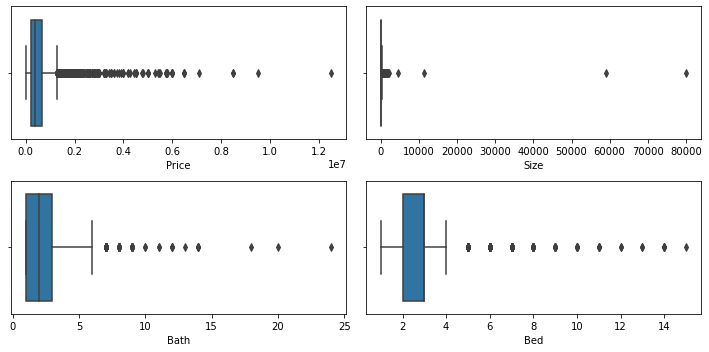

In [9]:
# Outlier Analysis
fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(df2['Price'], ax = axs[0,0])
plt2 = sns.boxplot(df2['Size'], ax = axs[0,1])
plt1 = sns.boxplot(df2['Bath'], ax = axs[1,0])
plt2 = sns.boxplot(df2['Bed'], ax = axs[1,1])

plt.tight_layout()

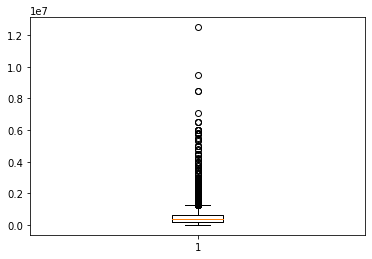

In [10]:
# outlier treatment for Price
plt.boxplot(df2.Price)
Q1 = df2.Price.quantile(0.25)
Q3 = df2.Price.quantile(0.75)
IQR = Q3 - Q1
df2 = df2[(df2.Price >= Q1 - 1.5*IQR) & (df2.Price <= Q3 + 1.5*IQR)]

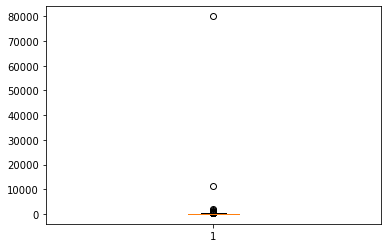

In [11]:
# outlier treatment for Size
plt.boxplot(df2.Size)
Q1 = df2.Size.quantile(0.25)
Q3 = df2.Size.quantile(0.75)
IQR = Q3 - Q1
df2 = df2[(df2.Size >= Q1 - 1.5*IQR) & (df2.Size <= Q3 + 1.5*IQR)]

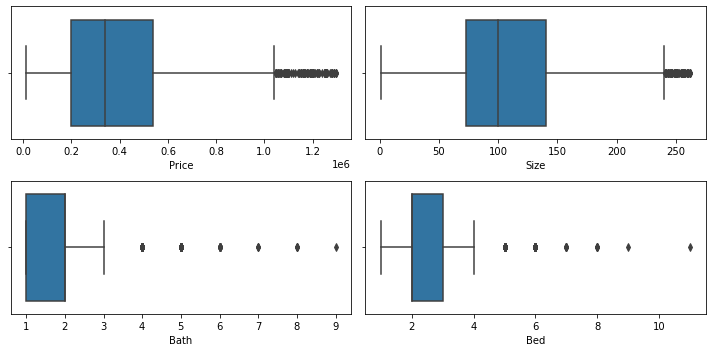

In [12]:
# Outlier Analysis
fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(df2['Price'], ax = axs[0,0])
plt2 = sns.boxplot(df2['Size'], ax = axs[0,1])
plt1 = sns.boxplot(df2['Bath'], ax = axs[1,0])
plt2 = sns.boxplot(df2['Bed'], ax = axs[1,1])

plt.tight_layout()

In [13]:
df2.describe()

,Price,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,Monthly_profit
count,5.122000e+03,5122.000000,5122.000000,5122.000000,5122.000000,5122.000000,5122.000000,5122.000000,5122.000000
mean,4.037081e+05,110.322335,1.875244,2.495900,0.409410,0.075947,0.308668,0.123389,-720.907689
std,2.596853e+05,49.438374,0.950573,1.050605,0.491773,0.264939,0.461989,0.328916,992.427576
min,1.250000e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-4987.107013
25%,1.990000e+05,73.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1206.515370
50%,3.392500e+05,100.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-393.151975
75%,5.390000e+05,140.000000,2.000000,3.000000,1.000000,0.000000,1.000000,0.000000,-34.223040
max,1.295000e+06,262.000000,9.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1588.578531


In [14]:
df2.drop(df2[(df2.Size ==1)].index, inplace=True)
df2.describe()

,Price,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,Monthly_profit
count,5.121000e+03,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000
mean,4.036551e+05,110.343683,1.874439,2.495411,0.409490,0.075962,0.308533,0.123413,-720.632129
std,2.596829e+05,49.419587,0.948916,1.050125,0.491788,0.264963,0.461933,0.328943,992.328500
min,1.250000e+04,17.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-4987.107013
25%,1.990000e+05,73.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-1206.261364
50%,3.390000e+05,100.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,-393.037994
75%,5.390000e+05,140.000000,2.000000,3.000000,1.000000,0.000000,1.000000,0.000000,-34.222115
max,1.295000e+06,262.000000,9.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1588.578531


In [15]:
df_class = df2.copy()
df_class = df_class.drop(columns = ['Price'])

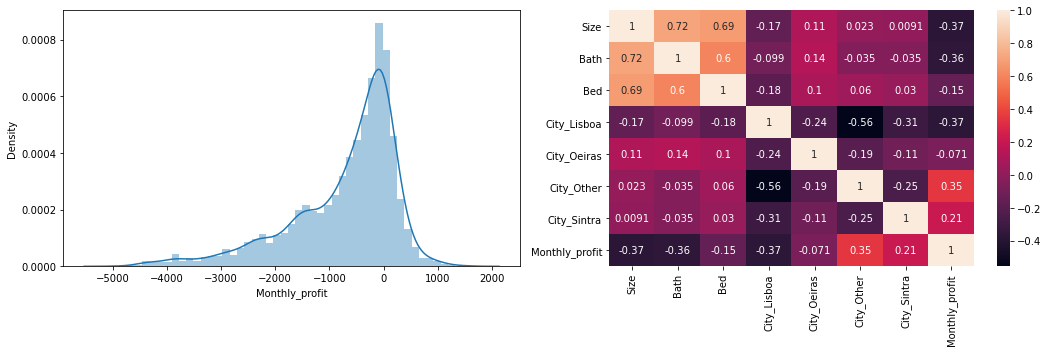

In [16]:
# histogram and heat map
corr = df_class.corr()
fig, axs = plt.subplots(1,2, figsize=[15,5])
sns.distplot(df_class['Monthly_profit'], ax=axs[0])
sns.heatmap(corr, ax=axs[1], annot=True)
fig.tight_layout()

In [17]:
df_class['good_prop'] = np.where(df_class['Monthly_profit'] > -300, 1, 0)  # good if monthly expense is less than 300
df_class = df_class.drop(columns = ['Monthly_profit'])
df_class.head()

,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,good_prop
0,80,1,3,0,0,1,0,1
1,250,2,5,0,0,0,1,1
2,123,4,4,0,0,0,1,1
3,101,1,2,0,0,1,0,0
6,118,3,4,0,0,1,0,0


In [18]:
df_class.describe()

,Size,Bath,Bed,City_Lisboa,City_Oeiras,City_Other,City_Sintra,good_prop
count,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000,5121.000000
mean,110.343683,1.874439,2.495411,0.409490,0.075962,0.308533,0.123413,0.446592
std,49.419587,0.948916,1.050125,0.491788,0.264963,0.461933,0.328943,0.497188
min,17.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,140.000000,2.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,262.000000,9.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df_class.to_csv(r'df_class_final.csv', index = False, header=True)

In [24]:
df_class = pd.read_csv('df_class_final.csv')

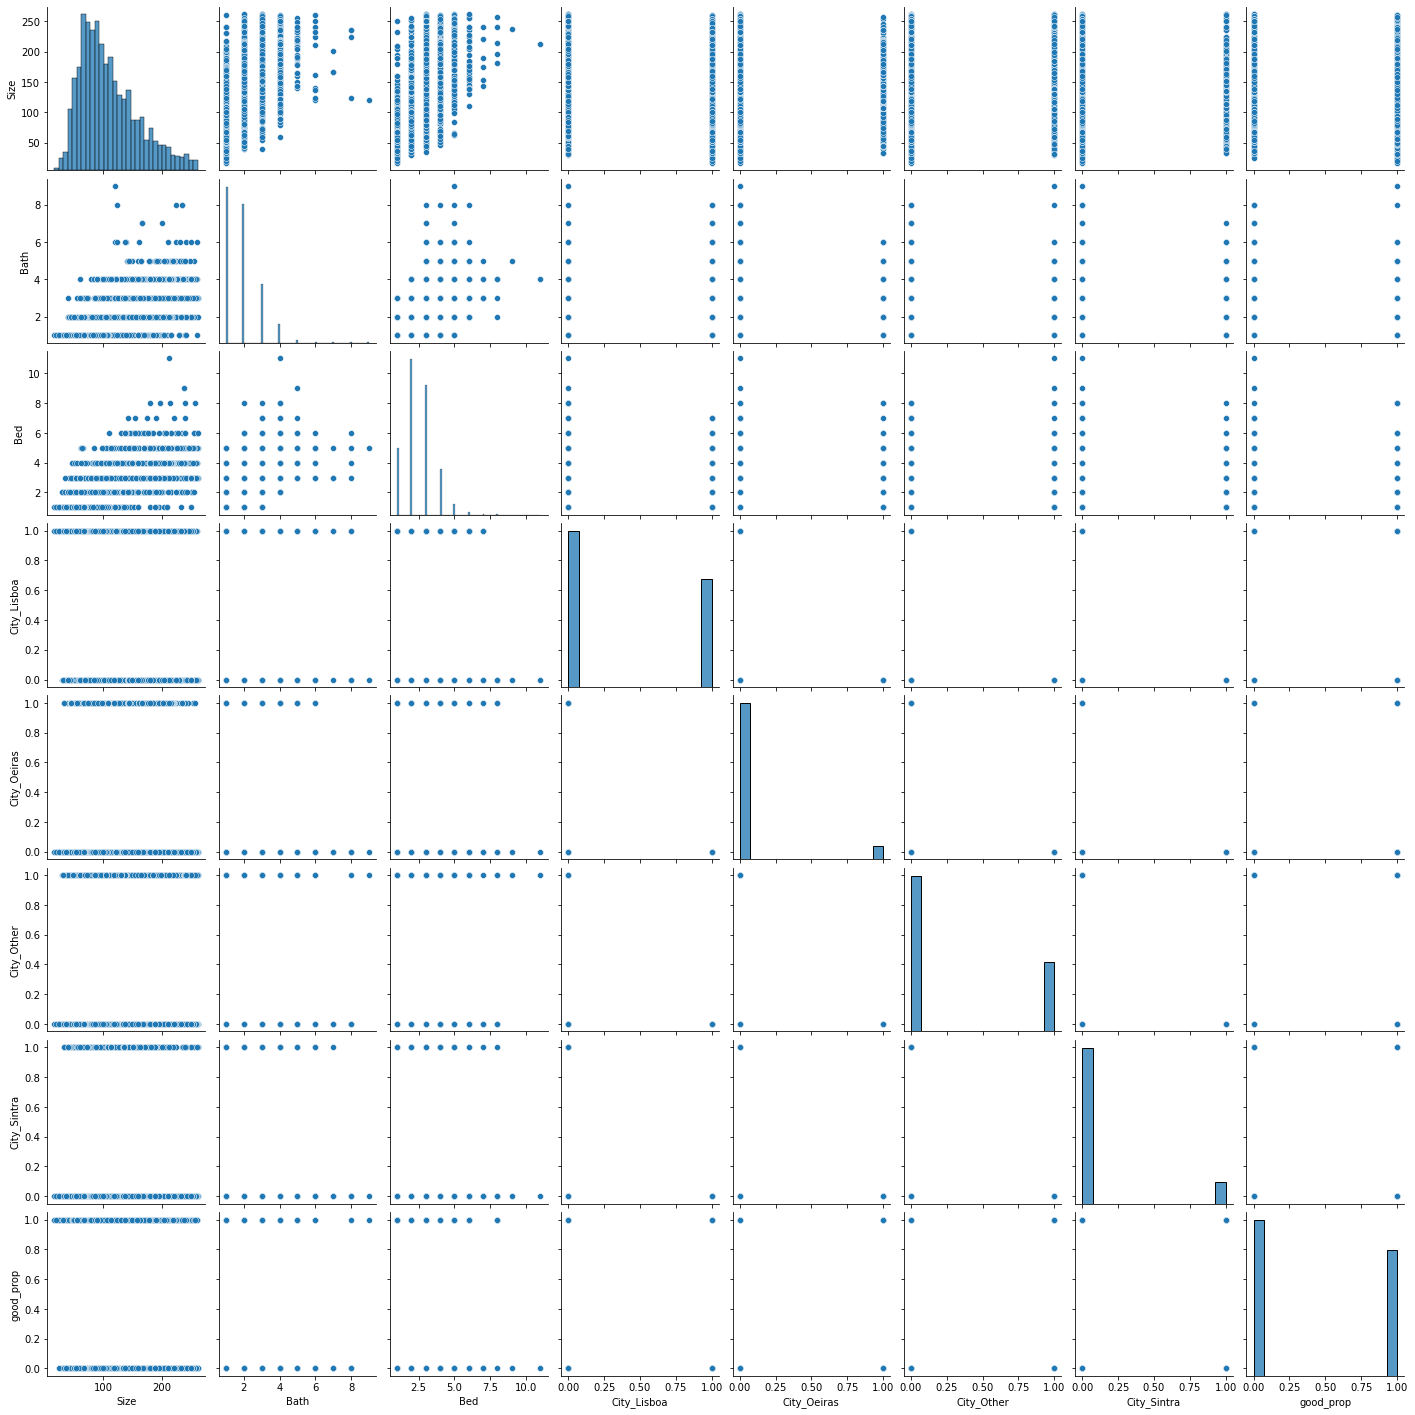

In [25]:
sns.pairplot(df_class)
plt.show()

Text(0, 0.5, 'Count')

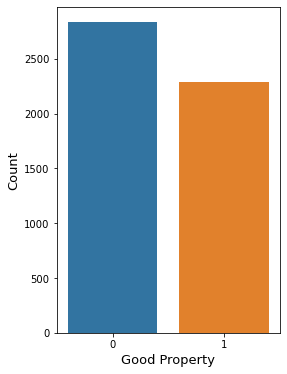

In [196]:
plt.figure(figsize=(4,6))

sns.countplot(x='good_prop', data=df_class)
plt.xlabel('Good Property', fontsize=13)
plt.ylabel('Count', fontsize=13)

In [27]:
# Check proportion of minor vs. major
print('not good: {}%'.format(round((df_class['good_prop'].value_counts()[0] / df_class.shape[0]), 2)*100))
print('good: {}%'.format(round((df_class['good_prop'].value_counts()[1] / df_class.shape[0]), 2)*100))

not good: 55.00000000000001%
good: 45.0%


In [ ]:
# Ready for classification model

In [93]:
X = df_class.drop(columns = ['good_prop'])
predictors = X.columns
y = df_class['good_prop']

### Logistic Regression

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

z = StandardScaler()
z.fit(X_train[['Size']])  # size is the only continuous var

X_train['Size'] = z.transform(X_train[['Size']])
X_test['Size'] = z.transform(X_test[['Size']])


In [95]:
lr = LogisticRegression()

In [96]:
lr.fit(X_train, y_train)

LogisticRegression()

In [97]:
lr_pred = lr.predict(X_test)

In [98]:
accuracy_score(y_test, lr_pred)

0.7404878048780488

In [99]:
precision, recall, fscore, support = score(y_test, lr_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')

Precision : 0.7402551737994776
Recall    : 0.7305282436861384
F-score   : 0.7326960784313725


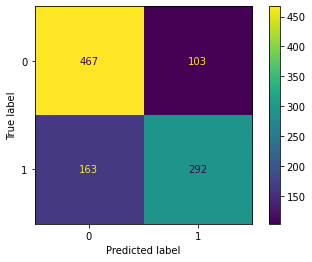

In [100]:
plot_confusion_matrix(lr, X_test, y_test)

In [101]:
# LR Coef interpretation
coef = pd.DataFrame({"Coefs": lr.coef_[0],  #[0] needed for Logistic Regression
                    "Names": predictors})  
coef = coef.append({"Coefs": lr.intercept_[0],  
                    "Names": "intercept"}, ignore_index = True)

In [102]:
# adding odds
coef['Odds Coefs'] = np.exp(coef['Coefs'])
coef

,Coefs,Names,Odds Coefs
0,-1.081393,Size,0.339123
1,-0.707064,Bath,0.493090
2,0.479945,Bed,1.615985
3,-0.992404,City_Lisboa,0.370684
4,-0.170498,City_Oeiras,0.843245
5,1.373707,City_Other,3.949968
6,2.413477,City_Sintra,11.172741
7,-0.528060,intercept,0.589748


In [103]:
ypred_prob = lr.predict_proba(X)

In [104]:
ypred_prob1 = ypred_prob[:, 1]

In [105]:
thresh = 0.5

ypred_prob_thresh = (ypred_prob1 > thresh) * 1
accuracy_score(y, ypred_prob_thresh)

0.5534075375903144

In [106]:
# regularization

lr_reg = LogisticRegression(penalty = 'none')
lr_reg.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [107]:
lr_reg_pred = lr_reg.predict(X_test)
accuracy_score(y_test, lr_reg_pred)

0.7404878048780488

### Decision Tree

In [108]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [109]:
tree_pred = tree.predict(X_test)

accuracy_score(y_test, tree_pred)

0.7541463414634146

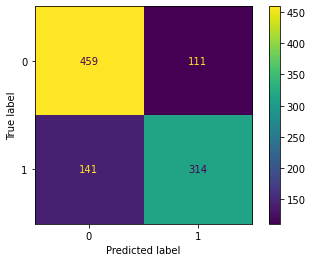

In [110]:
plot_confusion_matrix(tree, X_test, y_test)

In [111]:
tree.get_depth()

25

In [112]:
tree.get_n_leaves()

913

In [113]:
# reducing tree depth
tree15 = DecisionTreeClassifier(max_depth =15)
tree15.fit(X_train, y_train)
tree15_pred = tree.predict(X_test)
accuracy_score(y_test, tree15_pred)

0.7541463414634146

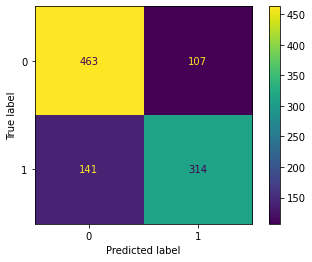

In [114]:
plot_confusion_matrix(tree15, X_test, y_test)

In [115]:
tree15.feature_importances_

array([0.42334769, 0.2348195 , 0.1004928 , 0.16366762, 0.01140144,
       0.03167702, 0.03459393])

### Model Comparison

Testing 6 different algorithms: <br>
Logistic Regression (LR) <br>
K-Nearest Neighbors (KNN) <br>
Random Forest (RF) <br>
Decision Trees (DT) <br>
Gaussian Naive Bayes (NB) <br>
Support Vector Machines (SVM)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

z = StandardScaler()
z.fit(X_train[['Size']])  # size is the only continuous var

X_train['Size'] = z.transform(X_train[['Size']])
X_test['Size'] = z.transform(X_test[['Size']])


In [149]:
# Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
models.append(('XGBoost', XGBClassifier(eval_metric='logloss')))

# Evaluate each model
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.759763 (0.010495)
KNN: 0.770513 (0.012539)
RF: 0.754407 (0.018004)
DT: 0.738298 (0.018056)
NB: 0.734373 (0.015546)
SVM: 0.774900 (0.010670)
XGBoost: 0.776619 (0.015374)


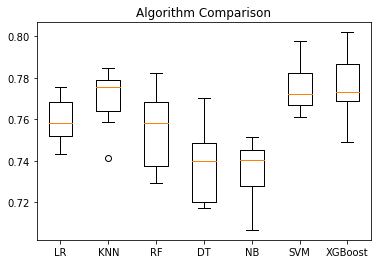

In [150]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [151]:
# Create list of model and accuracy dicts
summaryList = []

# List for storing scores
scores = []

In [152]:
# function to evaluate model and store scores

def model_eval(algorithm, name, X_train, y_train):

    class_model = algorithm

    # Calculate accuracy of train
    acc = cross_val_score(class_model, X_train, y_train).mean()

    class_model.fit(X_train, y_train)

    # Get predictions and probabilities
    y_preds = class_model.predict(X_test)
    y_score = class_model.predict_proba(X_test)

    # Calculate accuracy of test
    acc_test = round(accuracy_score(y_test, y_preds), 3)

    # Get precision, recall, f1-score
    precision, recall, fscore, support = score(y_test, y_preds, average='macro')

    # Add model and accuracy dict to list
    summaryList.append(dict([
        ('Model', name),
        ('Train Accuracy', round(acc, 3)),
        ('Test Accuracy', acc_test),
        ('Precision', round(precision, 3)),
        ('Recall', round(recall, 3)),
        ('F1', round(fscore, 3))
         ]))

    # Add y_score to list
    scores.append(y_score)

In [153]:
model_eval(LogisticRegression(), 'LR', X_train, y_train)
model_eval(KNeighborsClassifier(), 'KNN', X_train, y_train)
model_eval(RandomForestClassifier(), 'Random Forest', X_train, y_train)
model_eval(DecisionTreeClassifier(), 'Dec Tree', X_train, y_train)
model_eval(GaussianNB(), 'Gaussian NB', X_train, y_train)
model_eval(SVC(probability=True), 'SVM', X_train, y_train)
model_eval(XGBClassifier(eval_metric='auc'), 'XGBoost', X_train, y_train)

In [154]:
model_summary = pd.DataFrame(data=summaryList)
model_summary = model_summary[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_summary.drop_duplicates(inplace=True)
model_summary

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,LR,0.756,0.769,0.767,0.757,0.760
1,KNN,0.771,0.791,0.787,0.788,0.787
2,Random Forest,0.759,0.766,0.761,0.760,0.761
3,Dec Tree,0.747,0.755,0.751,0.747,0.748
4,Gaussian NB,0.735,0.749,0.749,0.735,0.738
5,SVM,0.774,0.790,0.787,0.783,0.785
6,XGBoost,0.784,0.794,0.791,0.788,0.789


In [155]:
def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2
    
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_test, scores[0][:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test, scores[0][:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR, AUC=%.3f' % auc_lr)
        
    # KNN
    fpr, tpr, thresholds = roc_curve(y_test, scores[1][:,1], pos_label=1)
    auc_knn = roc_auc_score(y_test, scores[1][:,1])
    plt.plot(fpr, tpr, color='y',
             lw=lw, label='KNN, AUC=%.3f' % auc_knn)
    
    # Random Forest
    fpr, tpr, thresholds = roc_curve(y_test, scores[2][:,1], pos_label=1)
    auc_rf = roc_auc_score(y_test, scores[2][:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Random Forest, AUC=%.3f' % auc_rf)
    
    # Decision Tree
    fpr, tpr, thresholds = roc_curve(y_test, scores[3][:,1], pos_label=1)
    auc_dt = roc_auc_score(y_test, scores[3][:,1])
    plt.plot(fpr, tpr, color='g',
             lw=lw, label='Decision Tree, AUC=%.3f' % auc_dt)
    
    # Gaussian NB
    fpr, tpr, thresholds = roc_curve(y_test, scores[4][:,1], pos_label=1)
    auc_nb = roc_auc_score(y_test, scores[4][:,1])
    plt.plot(fpr, tpr, color='c',
             lw=lw, label='Gaussian NB, AUC=%.3f' % auc_nb)
    
    # SVM
    fpr, tpr, thresholds = roc_curve(y_test, scores[5][:,1], pos_label=1)
    auc_svm = roc_auc_score(y_test, scores[5][:,1])
    plt.plot(fpr, tpr, color='m',
             lw=lw, label='SVM, AUC=%.3f' % auc_svm)    
    
    # XGBoost
    fpr, tpr, thresholds = roc_curve(y_test, scores[6][:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_test, scores[6][:,1])
    plt.plot(fpr, tpr, color='lime',
             lw=lw, label='XGBoost, AUC=%.3f' % auc_xgb)
    
    
    # Formatting
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=12)
    plt.legend(loc="lower right")
    plt.show()

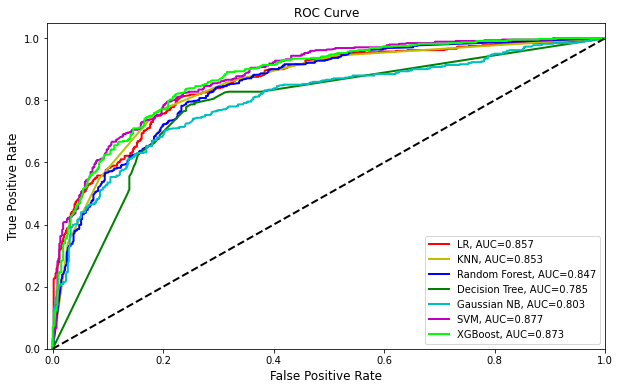

In [156]:
plot_roc_curves()

### Hyperparameter Grid Search for XGBoost

In [157]:
from datetime import datetime

In [158]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [187]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10, 20, 50], #[0, ∞]
        'gamma': [0.2, 0.4, 0.5, 1, 1.5, 2, 5, 10, 20, 50],   #[0, ∞]
        'subsample': [0.2, 0.4,0.5,0.6, 0.8, 1.0],   #[0,1]
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],   #[0,1]
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],   #[0, ∞] default=6
        'eta': [0.1, 0.2, 0.4, 0.8],         #[0,1]
        }

In [188]:
xgb = XGBClassifier(learning_rate=0.001, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [189]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 0 minutes and 6.1 seconds.


In [190]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([0.63358412, 0.47826104, 0.56116753, 0.74175582, 0.29434924]), 'std_fit_time': array([0.02767038, 0.00346141, 0.00902513, 0.00331756, 0.00444593]), 'mean_score_time': array([0.01339417, 0.00793185, 0.00593657, 0.00530763, 0.00627699]), 'std_score_time': array([0.00210792, 0.0007584 , 0.00059949, 0.00017532, 0.00020946]), 'param_subsample': masked_array(data=[0.6, 0.4, 0.4, 0.5, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 1, 50, 50, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 5, 6, 10, 7],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1, 5, 10, 20, 2],
             mask=[False, False, False, False, False],
       fill_value='?',
           

In [191]:
# optimized model
xgb_opt = XGBClassifier(learning_rate=0.001, n_estimators=600, objective='binary:logistic', eval_metric='auc', verbosity=0,
                    silent=True, nthread=1, subsample=0.6, min_child_weight=1, max_depth=6, gamma=1, eta=0.4, colsample_bytree=0.4)

In [192]:
model_eval(xgb_opt, 'XGBoost-opt', X_train, y_train)

In [193]:
model_summary = pd.DataFrame(data=summaryList)
model_summary = model_summary[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_summary.drop_duplicates(inplace=True)
model_summary

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,LR,0.756,0.769,0.767,0.757,0.760
1,KNN,0.771,0.791,0.787,0.788,0.787
2,Random Forest,0.759,0.766,0.761,0.760,0.761
3,Dec Tree,0.747,0.755,0.751,0.747,0.748
4,Gaussian NB,0.735,0.749,0.749,0.735,0.738
5,SVM,0.774,0.790,0.787,0.783,0.785
6,XGBoost,0.784,0.794,0.791,0.788,0.789
7,XGBoost-opt,0.788,0.815,0.812,0.808,0.810
10,XGBoost-opt,0.791,0.809,0.806,0.802,0.804
11,XGBoost-opt,0.761,0.773,0.781,0.754,0.759


In [166]:
xgb_opt_pred = xgb_opt.predict(X_test)

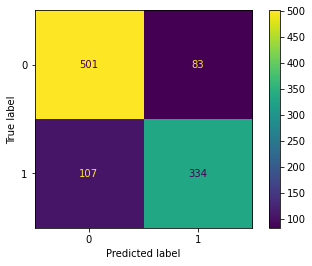

In [167]:
plot_confusion_matrix(xgb_opt, X_test, y_test)

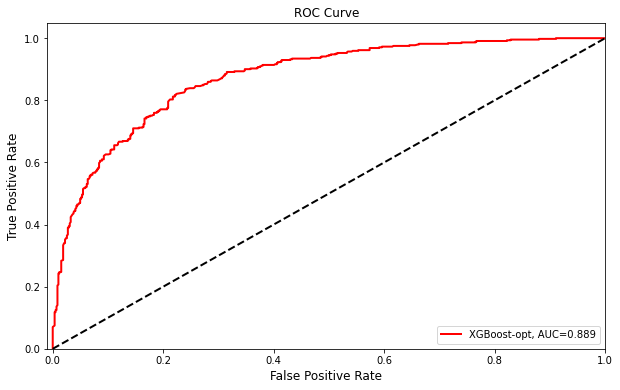

In [169]:
plt.figure(figsize=(10,6))
lw = 2

fpr, tpr, thresholds = roc_curve(y_test, scores[6][:,1], pos_label=1)
auc_xgb = roc_auc_score(y_test, scores[7][:,1])
plt.plot(fpr, tpr, color='r',
         lw=lw, label='XGBoost-opt, AUC=%.3f' % auc_xgb)

# Formatting
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=12)
plt.legend(loc="lower right")
plt.show()

In [194]:
xgb_opt.feature_importances_

array([0.02518307, 0.1638107 , 0.02788493, 0.38232392, 0.01934228,
       0.19256428, 0.18889073], dtype=float32)